This notebook refers the link below.

https://www.kaggle.com/code/hoshi7/bert-classify-news-sentiment/notebook

# Model training: 

Generally, for sentiment analysis, many techinques have been used for a long time. Some of them namely being:
- Bag of words
- Tf-IDF
- Word2vec, Glove

But, in the last few years, after Attention is all you need came up, transformers have been on the rise, leading to the creation of BERT. This bi directional model provides a lot of growth in accuracy as well as performance. 

In this notebook, the idea is to finetune a pretrained bert model to classify the sentiment of the news article. 

## Importing libraries

In [24]:
import transformers
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

#BERT data prep:

from transformers import BertTokenizer

from sklearn.model_selection import train_test_split


# Checking GPU 

In [25]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Setting up data

In [26]:
df = pd.read_csv('Sentiment_dataset.csv')
df_val = pd.read_csv('output.csv')

In [27]:
df.sentiment = df.sentiment.astype(int)

# Data Cleaning

- Prepare data for Bert using the BERT tokenizer

In order to apply the pre-trained BERT, we must prepare the data by using the tokenizer provided by the library. This is due to: 
- The model has a specific vocabulary 
- The BERT tokenizer has a certain way of preparing out of vocabulary words. 


Apart from this, BERT needs special tokens to the start and end of each sentence. 
Each sentence is also supposed to be padded and truncated to a single length, and each padding token is specified with an attention mask. 

Method will generally follow this approach: 
- Split text into tokens. 
- Add CLS and SEP tokens. 
- Convert tokens into indexes. 
- Pad or Truncate sentences to max length
- Create attention mask



In [28]:
# Splitting data into Validation and Training set
X = df.text.values
y = df.sentiment


# X_train = X
# y_train = y
# X_val = df_val.text.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=42)

In [29]:
# Loading the bert tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# using the bert base model, which has 768 tokens as the size. The uncased implies that data will be in a 
#single case and will not have multiple cases. This will allow the model to not overfit based on characters. 

In [30]:
# Function for preprocessing based on the steps provided: 

def preprocessing_for_bert(data):
    """
    
    Perform required preprocessing steps for pretrained BERT.
    
    Input: 
        - Param: data: Array of texts. 
    
    Returns: 
        - input_ids in the form of torch.Tensor
        - attention masks in torch.Tensor. These are indices which specify which tokens should be focused on by 
        the model
  
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in tqdm(data):
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        

        encoded_sent = tokenizer.encode_plus(
            text=sent,  
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad or Truncate sentences to max length
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since the approach would require sentences to be under 512 tokens, it is imperitive to proceed with a different method. 

There are two approaches that could be followed here: 

1. Each sequence truncated to 512 and measured. 
2. Each sequence split into senteces, seach sentence is encoded and then averaged out. 
3. Use a window method to split and encode. 

Generally, it has been found, that encoding to the first 512 is a great method to begin with. 

Thus, if that doesn't perform well, I will use a different approach. 

In [31]:
# Testing with first sentence
MAX_LEN = 510  # As that is the max length that is generally encoded. 

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([df.text.values[0]])[0].squeeze().numpy())
print('Original: ', df.text.values[0] )
# print('Token IDs: ', token_ids)



  0%|          | 0/1 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Billionaire investor and Shark Tank star Mark Cuban has launched a generic drug company called the Mark Cuban Cost Plus Drug Company.

The new company's website says it is dedicated to producing low-cost versions of high-cost generic drugs and pledges to "provide radical transparency in how we price our drugs."

The Cost Plus company will publish the costs to manufacture, distribute and market its drugs to pharmacies. It said it adds a 15 percent margin to get its wholesale prices and make sure it remains profitable, but that there are no middlemen and no rebates for insurance companies.

"Everybody gets the same low price for every drug we make," the company website states.

The first drug it will produce is albendazole, an antiparasitic drug. The company is hoping to introduce more than 100 drugs by the end of 2021, as well as build a pharmaceutical factory in Dallas by 2022.



The Mark Cuban Cost Plus Drug Company has also partnered with Baylor College of Medicine in Hou

/Users/apple/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
print('Tokenizing Data')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Tokenizing Data


  0%|          | 0/763 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

# Creating a Pytorch Dataloader

A dataloader allows for faster loading of data, thus making the training more efficient and it also helps to save on memory. 

In [33]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(np.array(y_train))
val_labels = torch.tensor(np.array(y_val))

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size =  16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [34]:
len(train_inputs)

763

# Training the model: 

### Create BertClassifier
BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

In [35]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

### Optimizer
To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

Batch size: 
- 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4


Huggingface provided the run_glue.py script, an examples of implementing the transformers library. In the script, the AdamW optimizer is used.

In [36]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=3e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=10, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Train: 

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:

- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (loss.backward())
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (optimizer.step())
- Update the learning rate (scheduler.step())


Evaluation:

- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop.

In [37]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [38]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

/Users/apple/miniconda3/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.425274   |     -      |     -     |  961.63  
   1    |   40    |   0.358655   |     -      |     -     |  684.03  
   1    |   47    |   0.397669   |     -      |     -     |  213.00  
----------------------------------------------------------------------
   1    |    -    |   0.393491   |  0.384942  |   86.25   |  1894.24 
----------------------------------------------------------------------


Training complete!


In [40]:
torch.cuda.empty_cache()

# Evaluation on validation set

In [41]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [44]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8354
Accuracy: 87.06%


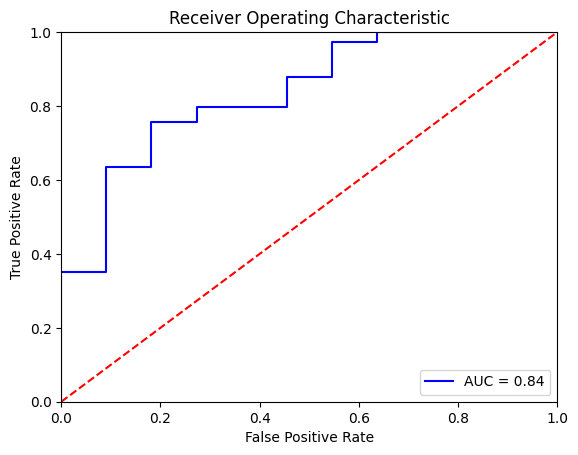

In [45]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)


In [ ]:
def predict_sentiment(url):
    '''
        Input:
            @param: url. A url from which information will be fetched. 
        Output:
            Sentiment: Boolean. 0/1. 0=Neg, 1=Pos
    
    
    '''
    
    article = Article(url)
    article.download()
    article.parse()
    url_text = article.text

    #Preprocess
    test_inputs, test_masks = preprocessing_for_bert([url_text])
    
    #Add to dataloader
    test_dataset = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)
    
    
    # Compute predicted. Threshold kept as 90% positive.
    
    # Compute predicted probabilities on the test set
    probs = bert_predict(bert_classifier, test_dataloader)

    # Get predictions from the probabilities
    threshold = 0.9
    preds = np.where(probs[:, 1] > 0.97, 1, 0)

    sentiment = preds[0]
    
    return sentiment

In [53]:
path = "sample12.csv"

In [47]:
def predict_sentiment_local(path):
    df = pd.read_csv(path)
    text = df.text
    
    #Preprocess
    test_inputs, test_masks = preprocessing_for_bert(text)
    
    #Add to dataloader
    test_dataset = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

    # Compute predicted probabilities on the test set
    probs = bert_predict(bert_classifier, test_dataloader)

    # Get predictions from the probabilities
    threshold = 0.9
    preds = np.where(probs[:, 1] > 0.97, 1, 0)

    sentiment = preds[0]

    return sentiment

In [54]:
sentiment = predict_sentiment_local(path)
print(sentiment)

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/apple/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0


In [55]:
torch.save(bert_classifier.state_dict(), "bert_news_sentiment_epoch1.pth")

In [56]:
model = bert_classifier
model.load_state_dict(torch.load('bert_news_sentiment_epoch1.pth'))
model.eval()  # Set the model to evaluation mode

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af